In [ ]:
!nvidia-smi

Sun Jul 13 14:28:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q supervision "ultralytics<=8.3.40"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00


In [ ]:
# prevent ultralytics from tracking your activity
!yolo settings sync=False

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": false,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [ ]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [ ]:
SOURCE_VIDEO_PATH = "/content/ml9.mp4"
TARGET_VIDEO_PATH = "ml9-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

In [ ]:
SOURCE = np.array([
    [1552, 100],   # was 600
    [3298, 100],   # was 620
    [5039, 1200],  # was 1900
    [-850, 1200]   # was 1900
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

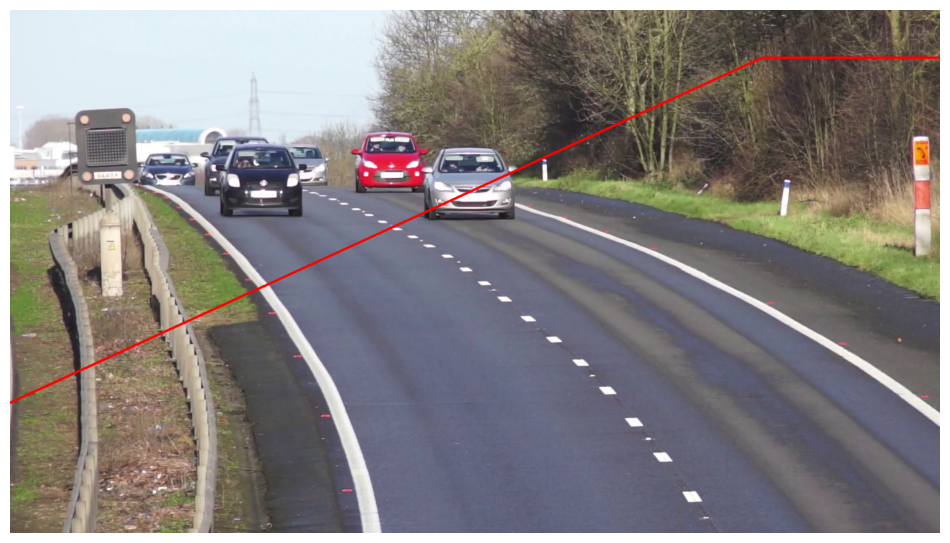

In [ ]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(
    scene=annotated_frame,
    polygon=SOURCE,
    color=sv.Color.RED,
    thickness=4
)
sv.plot_image(annotated_frame)

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [ ]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [ ]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracker initiation (corrected parameter name)
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps,
    track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Annotators configuration - using current supervision functions
thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_optimal_text_scale(
    resolution_wh=video_info.resolution_wh
)

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Zone setup - current correct implementation
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    triggering_anchors=[sv.Position.CENTER]  # Required in newer versions
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
100%|██████████| 298/298 [00:52<00:00,  5.67it/s]


In [ ]:
import csv
import os
import datetime


In [ ]:
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # your detection, tracking, and annotation code here
        sink.write_frame(annotated_frame)  # example


  0%|          | 0/298 [00:00<?, ?it/s]


In [ ]:
csv_file = "vehicle_speeds.csv"
saved_ids = set()  # track which vehicle speeds are already saved



# Create file and write header if it doesn't exist
if not os.path.exists(csv_file):
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["vehicle_id", "speed_kmph", "timestamp"])


In [ ]:
for tracker_id in detections.tracker_id:
    if len(coordinates[tracker_id]) >= video_info.fps / 2:
        # calculate speed
        coordinate_start = coordinates[tracker_id][-1]
        coordinate_end = coordinates[tracker_id][0]
        distance = abs(coordinate_start - coordinate_end)
        time = len(coordinates[tracker_id]) / video_info.fps
        speed = distance / time * 3.6
        vehicle_id = f"#{tracker_id}"
        labels.append(f"{vehicle_id} {int(speed)} km/h")

        # save to CSV only once
        vehicle_id = f"#{tracker_id}"
        labels.append(f"{vehicle_id} {int(speed)} km/h")

        if tracker_id not in saved_ids:
          timestamp = datetime.datetime.now().isoformat()
          with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([vehicle_id, speed, timestamp])
          saved_ids.add(tracker_id)
    else:
        labels.append(f"#{tracker_id}")
